In [2]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
df = pd.read_csv("Supermart Grocery Sales.csv")

12:48:24 - cmdstanpy - INFO - Chain [1] start processing
12:48:25 - cmdstanpy - INFO - Chain [1] done processing
12:48:25 - cmdstanpy - INFO - Chain [1] start processing
12:48:25 - cmdstanpy - INFO - Chain [1] done processing
12:48:25 - cmdstanpy - INFO - Chain [1] start processing
12:48:25 - cmdstanpy - INFO - Chain [1] done processing
12:48:26 - cmdstanpy - INFO - Chain [1] start processing
12:48:26 - cmdstanpy - INFO - Chain [1] done processing
12:48:26 - cmdstanpy - INFO - Chain [1] start processing
12:48:26 - cmdstanpy - INFO - Chain [1] done processing
12:48:26 - cmdstanpy - INFO - Chain [1] start processing
12:48:26 - cmdstanpy - INFO - Chain [1] done processing
12:48:26 - cmdstanpy - INFO - Chain [1] start processing
12:48:26 - cmdstanpy - INFO - Chain [1] done processing
12:48:27 - cmdstanpy - INFO - Chain [1] start processing
12:48:27 - cmdstanpy - INFO - Chain [1] done processing


            Category  Monthly MAPE
0             Bakery     25.160769
1          Beverages     29.463605
2  Eggs, Meat & Fish     42.368706
3        Food Grains     32.257601
4   Fruits & Veggies     34.056793
5       Oil & Masala     46.251894
6             Snacks     19.082167


12:48:27 - cmdstanpy - INFO - Chain [1] start processing
12:48:27 - cmdstanpy - INFO - Chain [1] done processing
12:48:27 - cmdstanpy - INFO - Chain [1] start processing
12:48:27 - cmdstanpy - INFO - Chain [1] done processing
12:48:27 - cmdstanpy - INFO - Chain [1] start processing
12:48:27 - cmdstanpy - INFO - Chain [1] done processing
12:48:28 - cmdstanpy - INFO - Chain [1] start processing
12:48:28 - cmdstanpy - INFO - Chain [1] done processing
12:48:28 - cmdstanpy - INFO - Chain [1] start processing
12:48:28 - cmdstanpy - INFO - Chain [1] done processing
12:48:28 - cmdstanpy - INFO - Chain [1] start processing
12:48:28 - cmdstanpy - INFO - Chain [1] done processing


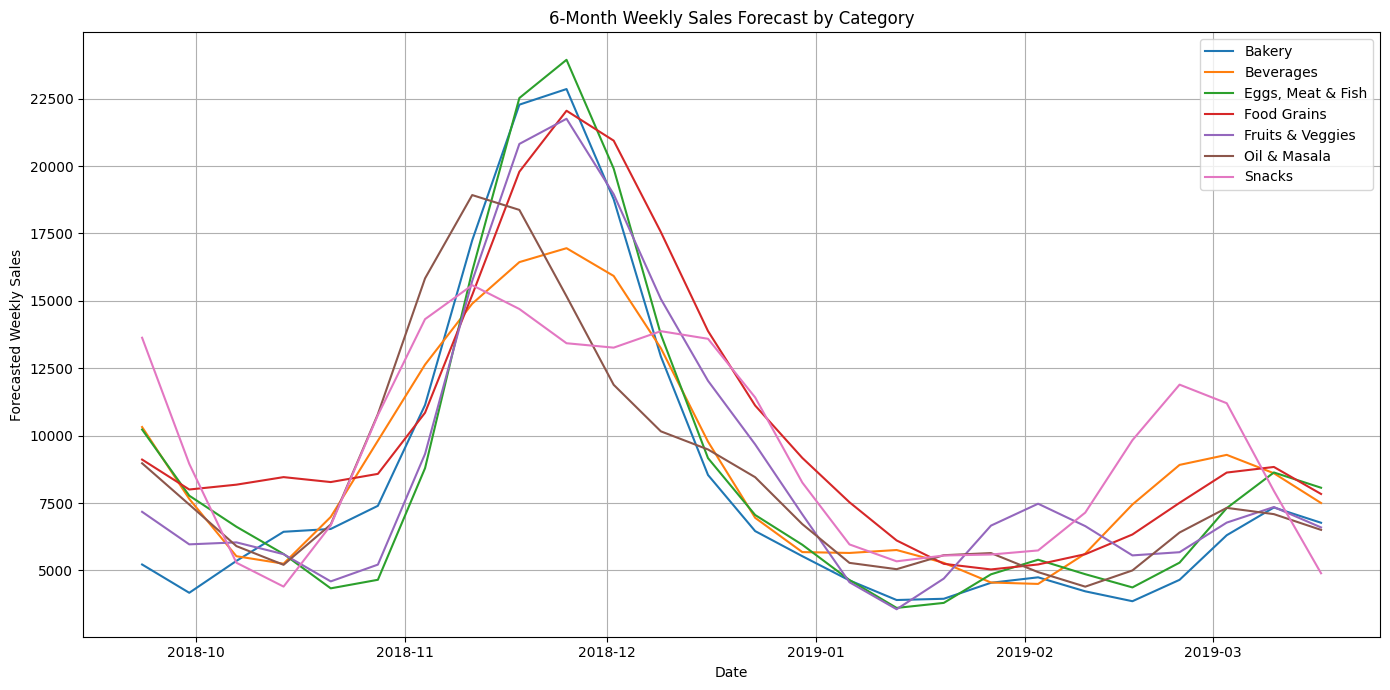

In [4]:
from sklearn.metrics import mean_absolute_percentage_error

# --- Step 1: Preprocessing ---
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df = df[['Order Date', 'Category', 'Sales']].dropna()

# --- Step 2: Train-test split ---
cutoff_date = pd.to_datetime('2018-10-01')
train_df = df[df['Order Date'] < cutoff_date]
test_df = df[df['Order Date'] >= cutoff_date]

# --- Step 3: Aggregate weekly sales by category ---
train_df.set_index('Order Date', inplace=True)
test_df.set_index('Order Date', inplace=True)

train_weekly = train_df.groupby([pd.Grouper(freq='W'), 'Category'])['Sales'].sum().reset_index()
test_weekly = test_df.groupby([pd.Grouper(freq='W'), 'Category'])['Sales'].sum().reset_index()

# --- Step 4: Pivot for Prophet ---
pivot_train = train_weekly.pivot(index='Order Date', columns='Category', values='Sales').fillna(0)

# Forecast test period: 13 weeks
forecast_weeks = 13
results = []
metrics = []

for category in pivot_train.columns:
    # Prepare data
    temp = pivot_train[[category]].reset_index().rename(columns={
        'Order Date': 'ds',
        category: 'y'
    })

    model = Prophet()
    model.fit(temp)

    future = model.make_future_dataframe(periods=forecast_weeks, freq='W')
    forecast = model.predict(future)

    forecast_test = forecast[['ds', 'yhat']].tail(forecast_weeks)
    forecast_test['Category'] = category

    # Actuals for this category
    actuals = test_weekly[test_weekly['Category'] == category].copy()
    actuals = actuals.groupby('Order Date')['Sales'].sum().reset_index()
    actuals = actuals.rename(columns={'Order Date': 'ds', 'Sales': 'actual'})

    # Merge
    merged = pd.merge(forecast_test, actuals, on='ds', how='inner')
    merged['abs_error'] = (merged['yhat'] - merged['actual']).abs()

    # --- Monthly MAPE Calculation ---
    merged['Month'] = merged['ds'].dt.to_period('M')
    monthly = merged.groupby('Month').agg({'actual': 'sum', 'yhat': 'sum'}).reset_index()
    monthly_mape = mean_absolute_percentage_error(monthly['actual'], monthly['yhat']) * 100

    # Save category-specific result
    metrics.append({
        'Category': category,
        'Monthly MAPE': monthly_mape
    })

metrics_df = pd.DataFrame(metrics)
print(metrics_df[['Category', 'Monthly MAPE']])
   
# Optional: Forecast next 6 months
future_forecasts = []
for category in pivot_train.columns:
    temp = pivot_train[[category]].reset_index().rename(columns={
        'Order Date': 'ds',
        category: 'y'
    })

    model = Prophet()
    model.fit(temp)
    future = model.make_future_dataframe(periods=26, freq='W')
    forecast = model.predict(future)
    last_train_date = temp['ds'].max()
    future_only = forecast[forecast['ds'] > last_train_date].copy()
    future_only['Category'] = category
    future_forecasts.append(future_only[['ds', 'yhat', 'Category']])

# Combine future forecasts
combined_future = pd.concat(future_forecasts).rename(columns={'ds': 'Date', 'yhat': 'Forecast'})

# Plot future forecast
plt.figure(figsize=(14, 7))
for category in combined_future['Category'].unique():
    data = combined_future[combined_future['Category'] == category]
    plt.plot(data['Date'], data['Forecast'], label=category)

plt.title("6-Month Weekly Sales Forecast by Category")
plt.xlabel("Date")
plt.ylabel("Forecasted Weekly Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


12:48:33 - cmdstanpy - INFO - Chain [1] start processing
12:48:33 - cmdstanpy - INFO - Chain [1] done processing


Forecast Evaluation Metrics for Oct–Dec 2018:
MAPE: 35.52%


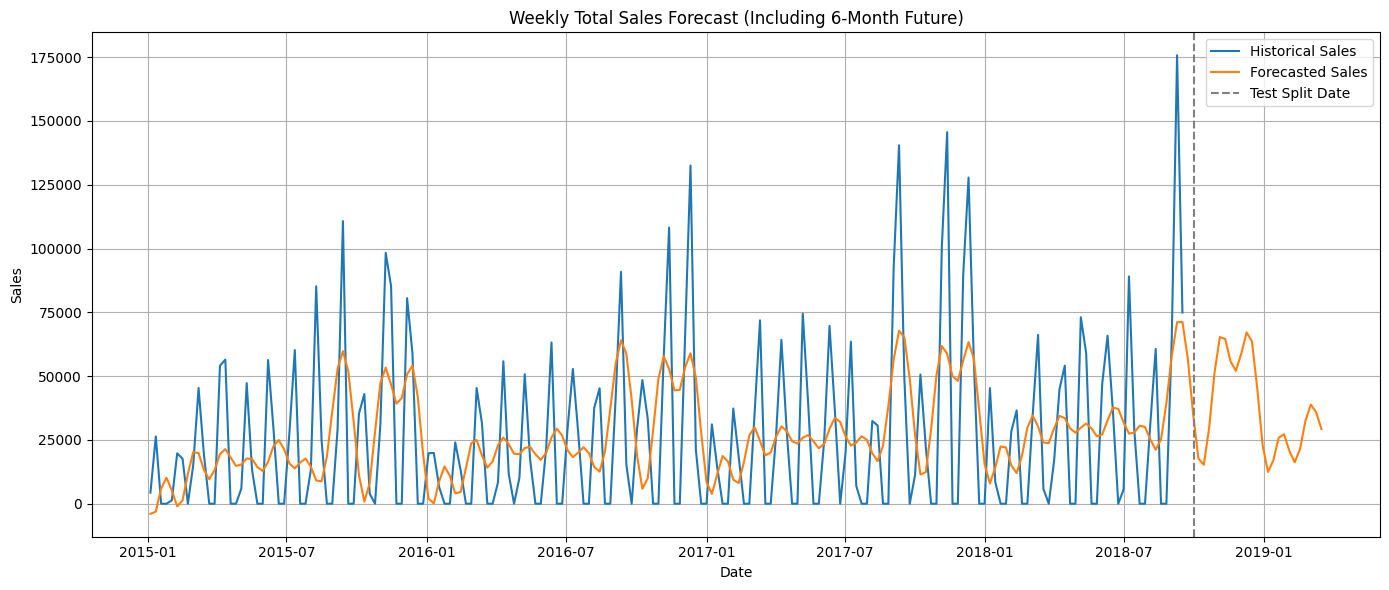

In [5]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# --- Step 1: Preprocessing ---
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df = df[['Order Date', 'Sales']].dropna()

# --- Step 2: Train-test split ---
cutoff_date = pd.to_datetime('2018-10-01')
train_df = df[df['Order Date'] < cutoff_date]
test_df = df[df['Order Date'] >= cutoff_date]

# --- Step 3: Aggregate weekly sales ---
train_df.set_index('Order Date', inplace=True)
test_df.set_index('Order Date', inplace=True)

train_weekly = train_df.resample('W')['Sales'].sum().reset_index()
test_weekly = test_df.resample('W')['Sales'].sum().reset_index()

# --- Step 4: Prepare for Prophet ---
prophet_train = train_weekly.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

# --- Step 5: Train Model ---
model = Prophet()
model.fit(prophet_train)

# --- Step 6: Forecast next 13 weeks (test set period) ---
forecast_weeks = 13
future = model.make_future_dataframe(periods=forecast_weeks, freq='W')
forecast = model.predict(future)

# --- Step 7: Evaluation on test period ---
forecast_test = forecast[['ds', 'yhat']].tail(forecast_weeks)

# Align test actuals
actuals = test_weekly.rename(columns={'Order Date': 'ds', 'Sales': 'actual'})
merged = pd.merge(forecast_test, actuals, on='ds', how='inner')
merged['error'] = merged['yhat'] - merged['actual']
merged['abs_error'] = merged['error'].abs()

 # --- Monthly MAPE Calculation ---
merged['Month'] = merged['ds'].dt.to_period('M')
monthly = merged.groupby('Month').agg({'actual': 'sum', 'yhat': 'sum'}).reset_index()
monthly_mape = mean_absolute_percentage_error(monthly['actual'], monthly['yhat']) * 100


print("Forecast Evaluation Metrics for Oct–Dec 2018:")

print(f"MAPE: {monthly_mape:.2f}%")

# --- Step 8: Forecast future 6 months (26 weeks) ---
future_6m = model.make_future_dataframe(periods=26, freq='W')
forecast_6m = model.predict(future_6m)

# Extract only future values
last_train_date = prophet_train['ds'].max()
future_only = forecast_6m[forecast_6m['ds'] > last_train_date][['ds', 'yhat']]

# --- Step 9: Plot ---
plt.figure(figsize=(14, 6))
plt.plot(prophet_train['ds'], prophet_train['y'], label='Historical Sales')
plt.plot(forecast_6m['ds'], forecast_6m['yhat'], label='Forecasted Sales')
plt.axvline(x=cutoff_date, color='gray', linestyle='--', label='Test Split Date')
plt.title("Weekly Total Sales Forecast (Including 6-Month Future)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
combined_future.to_csv("combined_future.csv", index=False)
future_only.rename(columns={'ds': 'Date', 'yhat': 'Forecast'}).to_csv("total_future.csv", index=False)
